# Tutorial for geometry.py

This notebook will introduce some of the most useful functionalities of the geometry.py class. The geometry.py module allows you to manipulate geometry file types of typical DFT codes. It has a focus on surface geometries.

First we load the necessary dependecies:

In [64]:
import numpy as np
from dfttools import geometry

## Creating a surface slab

Let us start by reating a surface slab. First, we load a geometry and print the coordinates of the atoms in it. We are loading an AIMS-geometry, so we use the AimsGeometry class. There are also VaspGeometry and XYZGeometry classes. We use the <code>get_text</code> function to plrint the content of the geometry file.

In [65]:
geom = geometry.AimsGeometry('data/bulk_substrate.in')

print(geom.get_text())

lattice_vector     1.79800000     1.79800000     0.00000000
lattice_vector     1.79800000     0.00000000     1.79800000
lattice_vector     0.00000000     1.79800000     1.79800000
atom     0.00000000     0.00000000     0.00000000 Cu



Let us now visualise the geoemtry. The visualise function has **many** keyword parameters, all of which are very useful. But for a quick overview you don't need them. We will introduce some of them later on.

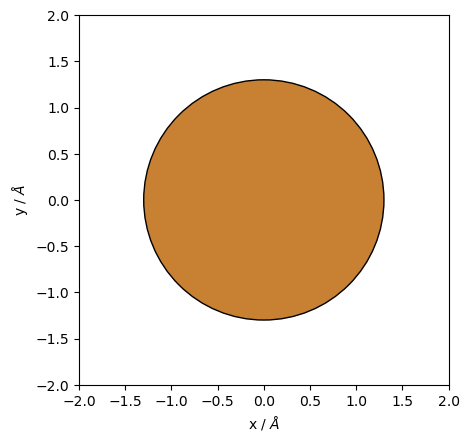

In [66]:
geom.visualise()

It turns out we loaded a single copper atom. In fact, we loaded a bulk unit cell of copper, containing a single atom. Let's check it we have periodic boundary conditions.

In [67]:
geom.get_is_periodic()

True

It seems that our geometry is periodic. Let's make a lager patch of copper atoms using the periodica replica function.

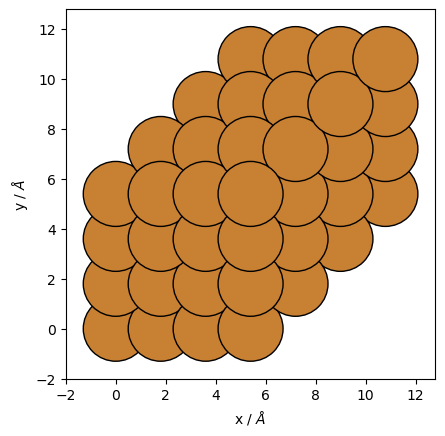

In [68]:
geom_rep = geom.get_periodic_replica((4,4,4))
geom_rep.visualise()

Great! We now have a patch of copper atoms. The <code>get_periodic_replica</code> function also replicates the lattice vectors and any other atom-wise property.

Let us now create a (111)-surface slab.

[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29]


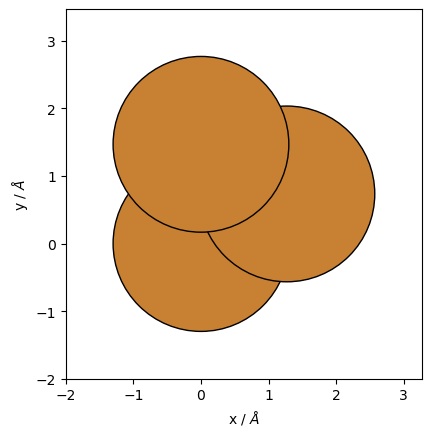

In [69]:
geom_surf = geom.get_primitive_slab((1, 1, 1))
geom_surf.visualise()

The visualise function can look at the structure from different angles using the <code>axes</code> keyword. It takes a tuple as input, where the two integers indicate the axes. We will look at the x and z-axes.

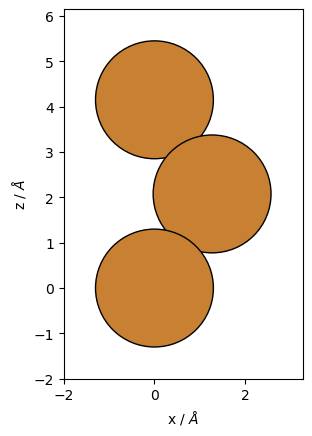

In [70]:
geom_surf.visualise(axes=[0,2])

Now we have a slab, containing three layers. Let us replicate it with the <code>get_periodic_replica</code> function to get a surface unit cell. Note that we replicate 8 times in x, 8 times in y and only 1 time in z direction. I.e. we just keep our 3 layers in z-direction.

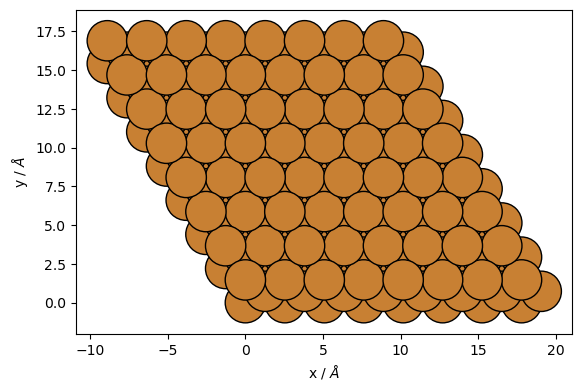

In [71]:
geom_surf_rep = geom_surf.get_periodic_replica((8,8,1))
geom_surf_rep.visualise()

## Adding a molecule

We will now add a molecule to our slab. We will first load and visulaise it.

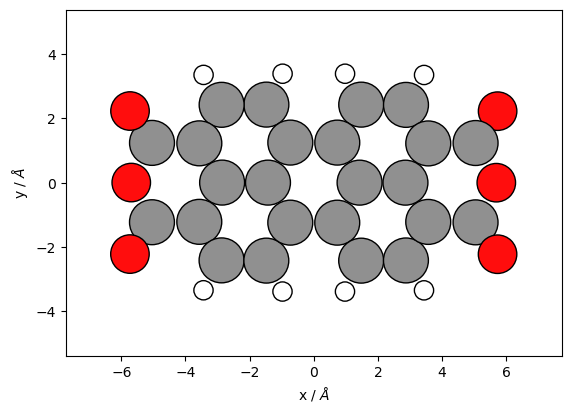

In [72]:
mol = geometry.AimsGeometry('data/molecule.in')
mol.visualise()

Ok, that's nice. But it is too horizontal. Let's rotate the molecule around the z-axis using the <code>rotate_coords_around_axis</code> function. By default, it will rotate around the z-axis, but you can give it any axis you like. The rotate function manipulates in place. Function that return a new geometry start with <code>get_</code>.

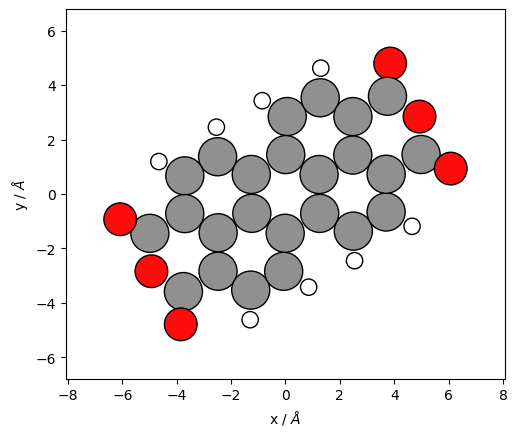

In [73]:
mol.rotate_coords_around_axis(30)
mol.visualise()

That's a better angle. Let's add it to the surface slab. First, we grab the highest z-coordinate of the substrate and the lowest z-coordinate of the molecule. There we have to get manually from <code>geom.coords</code>.

In [74]:
z_offset = np.max(geom_surf_rep.coords[:,2]) - np.min(mol.coords[:,2])

Let's place our molecule 3 Angstrom above the slab. The units geometry.py works in are Angstrom. So we add 3 to <code>z_offset</code> and move our molecule in z-direction.

In [75]:
z_move = np.array([0, 0, z_offset + 3])
mol.move_all_atoms(z_move)

Now we just add <code>mol</code> to <code>geom_surf_rep</code>.

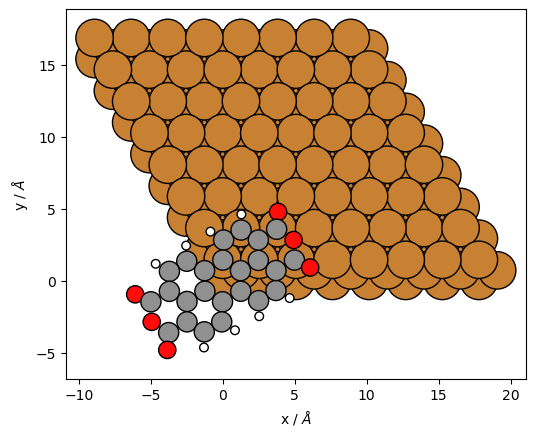

In [76]:
geom_mol = geom_surf_rep + mol
geom_mol.visualise()

## Removing atoms

Ok ... well ... it sticks out. I don't like it. So let's remove the molecule and start over again. We can remove molecules with the <code>remove_adsorbates</code> function. You can give it the <code>primitive_substrate</code>, but you don't have to. If you don't the code will assume that your has any of these atomic numbers $Z > 18 \vee Z \in \{3, 4, 11, 12, 13, 14\}$. This is a bit risky so the code will produce a warning. We'll just ignore it.

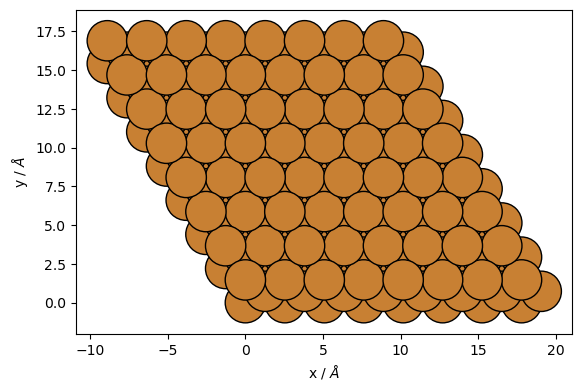

In [77]:
geom_mol.remove_adsorbates()
geom_mol.visualise()

## Manipulating a geometry

Let's now move our molecule. But first we will do some prep-work. First we will center our geometry.

In [78]:
mol.center_coordinates()

array([ 4.91550000e-05, -2.41797632e-04,  7.15230314e+00])

Then we will align our molecule with the Cartesian axes again.

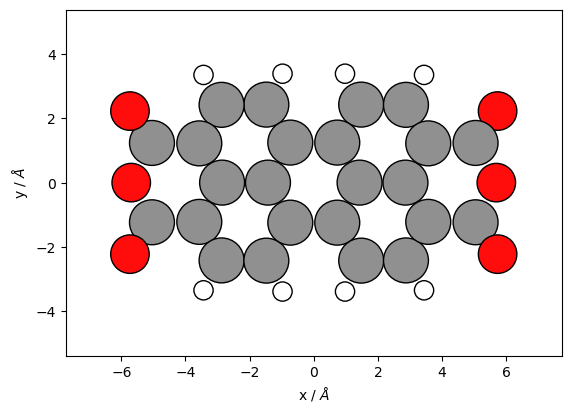

In [79]:
mol.align_main_axis_along_xyz()
mol.visualise()

Now that we have our molecule back to normal, we are ready to move it again. We could move it with <code>move_all_atoms</code> if we know the distances in Cartesian coordinates. We can also move the molecule by fractional coordinates. To do this we will use <code>move_all_atoms_by_fractional_coords</code> and use the primitive substrate lattice vectors of <code>geom_surf</code>.

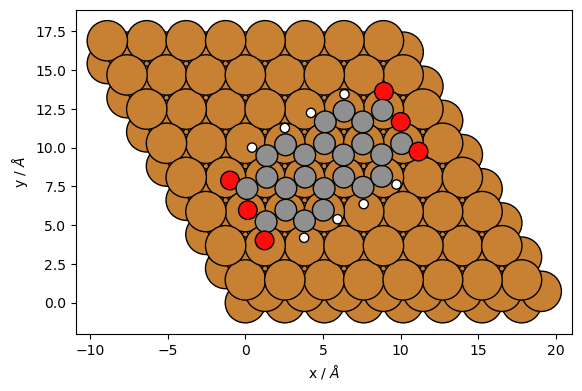

In [80]:
# Rotate the molecule
mol.rotate_coords_around_axis(30)

# Move molecule in z-direction in Cartesian coordinates
mol.move_all_atoms(z_move)

# Get primitive substrate lattice vectors
lattice = geom_surf.lattice_vectors

# Move molecule in fractinal coordinates
mol.move_all_atoms_by_fractional_coords((4,4,0), lattice_vectors=lattice)

# Add molecule to slab
geom_surf_rep += mol

# Visualise
geom_surf_rep.visualise()

## Saving geomeries

That's how it's supposed to be. Now that we have a nice geometry we want to save it. This is easy:

In [81]:
geom_surf_rep.save_to_file('temp/whatever_name_you_facy.in')

But what if we want to use VASP to calculate it? Then we'll just convert our geometry. Then we could save it. But for the purpose of this tutorial, we will just look at the text in the geomertry here, using the <code>get_text</code> function.

In [82]:
geom_vasp = geom_surf_rep.get_instance_of_other_type('vasp')
print(geom_vasp.get_text())

POSCAR file written by Geometry.py
1
20.34204788     0.00000000     0.00000000
-10.17102394     17.61673023     0.00000000
0.00000000     -0.00000000     6.22845470
C Cu H O
24 192 8 6
Selective dynamics
Cartesian
 2.58990956     10.17477521     7.15230314
 1.38535560     9.47142923     7.15230314
 1.38413640     8.08394742     7.15230314
 2.61106470     7.37965893     7.15230314
 2.60739814     5.96492428     7.15230314
 3.80957969     5.27222579     7.15230314
 5.02112797     5.96364802     7.15230314
 5.07584970     7.36189115     7.15230314
 3.84942058     8.09451903     7.15230314
 3.82810411     9.52289426     7.15230314
 5.09533053     10.25456951     7.15230314
 6.32173296     9.52199616     7.15230314
 6.34310889     8.09357405     7.15230314
 7.58140142     7.44186489     7.15230314
 8.78589220     8.14539924     7.15230314
 8.78701023     9.53288080     7.15230314
 7.55999051     10.23702066     7.15230314
 7.56346010     11.65174422     7.15230314
 6.36122837     12.3443817